In [10]:
import pandas as pd
import geopandas as gpd
import folium
import ipywidgets as widgets
import pylab as pl, branca.colormap as bcm
import matplotlib as mpl, matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
#np.seterr(divide='ignore', invalid='ignore',)

In [11]:
eval=pd.read_csv('evalXL.csv')
background=pd.read_csv('backgroundXL.csv')
results = gpd.read_file('results.geojson')

In [31]:
from ipywidgets import Layout

style = {'description_width': 'initial'}

w_indicator = widgets.Dropdown(options=[('SocioEconomic Risk','SERank'), ('Env Health Disparities','EHDRank'),('Low Income Population','LWINRank'),('Minority Population','MINRank')],
                 description='Indicator:',
                 disabled=False,
                 style=style,
                 layout = Layout(width='50%', height='40px', display='flex'))

w_region = widgets.SelectMultiple(options=background.StateDistrict.unique(),
                 description='Regions:',
                 disabled=False,
                 style=style,
                 layout = Layout(width='50%', height='120px', display='flex'))

In [96]:
colormap2=bcm.LinearColormap(
        ['#053061','#2166ac','#4393c3','#4393c3','#4393c3','#d6604d','#b2182b','#b2182b','#b2182b','#67001f','#67001f'],
        index=[1,2,3,4,5,6,7,8,9,10],vmax=10
    )
    
colormap2(5)

'#4393c3ff'

In [110]:
def update_map(region,limit):
    
    
    results['target']=results[limit]
    select_visits=eval[eval['StateDistrict'].isin(region)]
    select_facilities=background[background['StateDistrict'].isin(region)]
    
    layer_alpha=.1
    color_alpha=.1
    m = folium.Map(location=[47.527212,-120.5469224], zoom_start=7, tiles='cartodbpositron', width='80%', height='80%')


    colormap=bcm.LinearColormap(
        ['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f','#67001f'],
        index=[1,2,3,4,5,6,7,8,9,10],vmax=10
    )
    colormap.caption = 'Decile Rank (Low-High)'
    colormap.add_to(m)

    
    Visits = folium.FeatureGroup(name='Visits', show=True)
    NoVisits = folium.FeatureGroup(name='Facilities', show=True)
    EJM = folium.FeatureGroup(name=w_indicator.label, show=False)
    CodedVisits = folium.FeatureGroup(name='Coded Visits', show=False)
    CodedFacilities = folium.FeatureGroup(name='Coded Facilities', show=False)    

    EJMchoropleth = folium.GeoJson(results.to_json(),
                            name='result4',
                            highlight_function=lambda x: {'color':'#000000', 'weight':2,'fillOpacity':.5},
                            style_function=lambda x :{'fillColor':colormap(x['properties']['target']),
                                                      'color':colormap(x['properties']['target']),'weight':.5,'fillOpacity':color_alpha},
                            tooltip=folium.features.GeoJsonTooltip(fields=[limit], aliases=[limit], style=('background-color:rgba(255, 255, 255, 0.7); color: black; font-family:courier new; font-size: 7px; padding: 0px;'),sticky=True))
    
    select_visits.apply(lambda row:folium.CircleMarker(location=[row["LocationLatitude"], row["LocationLongitude"]],
                                              highlight_function=lambda x: {"weight":3,'fillOpacity':0.95,'zoom':8},
                                              radius=5, color='green',weight=1,show=True, fill_color='green',popup=folium.map.Popup('<a href="http://ecyaphwtr/turboplan/Pages/PlanHome.aspx?PlanID='+str(row['PlanID'])+'">'+row['FacilityName']+'</a><br> '+row['FirstName']+'<br>'+str(row['StaffReminderDate']),max_width=150))
                                             .add_to(Visits), axis=1)
    
    select_visits.apply(lambda row:folium.CircleMarker(location=[row["LocationLatitude"], row["LocationLongitude"]],
                                              highlight_function=lambda x: {"weight":3,'fillOpacity':0.95,'zoom':8},
                                              radius=6, color=colormap2(row[limit]),weight=1,fill_opacity=.8, fill_color=colormap(row[limit]),
                                                       popup=folium.map.Popup('<a href="http://ecyaphwtr/turboplan/Pages/PlanHome.aspx?PlanID='+str(row['PlanID'])+'">'+row['FacilityName']+'</a><br> '+row['FirstName']+'<br>'+str(row['StaffReminderDate']+'<br>'+str(limit)+': '+str(row[limit])),max_width=200))
                                             .add_to(CodedVisits), axis=1)
                                              
                                              
    select_facilities.apply(lambda row:folium.CircleMarker(location=[row["LocationLatitude"], row["LocationLongitude"]], 
                                              radius=3, color='black',weight=.5, fill_color='grey',fill_opacity=.5,popup='<a href="http://ecyaphwtr/turboplan/Pages/PlanHome.aspx?PlanID='+str(row['PlanID'])+'">'+row['FacilityName']+'</a><br>'+row['FullName'],max_width=200)
                                             .add_to(NoVisits), axis=1)
    
    select_facilities.apply(lambda row:folium.CircleMarker(location=[row["LocationLatitude"], row["LocationLongitude"]], 
                                              radius=3, color='black',weight=.5, fill_color=colormap(row[limit]),fill_opacity=.6,
                                                           popup='<a href="http://ecyaphwtr/turboplan/Pages/PlanHome.aspx?PlanID='+str(row['PlanID'])+'">'+row['FacilityName']+'</a><br>'+row['FullName']+'<br>'+str(limit)+': '+str(row[limit]),max_width=200)
                                             .add_to(CodedFacilities), axis=1)
    Visits.add_to(m)
    NoVisits.add_to(m)
    CodedVisits.add_to(m)
    CodedFacilities.add_to(m)
    m.keep_in_front(NoVisits)
    m.keep_in_front(CodedFacilities)   
    m.keep_in_front(Visits)
    m.keep_in_front(CodedVisits)

    EJMchoropleth.add_to(EJM)
    EJM.add_to(m)
    
    folium.TileLayer('cartodbpositron').add_to(m)
    folium.LayerControl().add_to(m)

    title = 'Planning Facilities and Visits Across Vulnerable Communities ('+w_indicator.label+')'
    title_html = '''<h3 align="center" style="font-size:16px"><b>{}</b></h3>'''.format(title)   
    m.get_root().html.add_child(folium.Element(title_html))

    display(m)
    
    background2=background[background['StateDistrict'].isin(region)]
    eval2=eval[eval['StateDistrict'].isin(region)]
    
    fig = plt.figure(figsize=(18,18),constrained_layout=True)
    gs1 = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

    plot1 = fig.add_subplot(gs1[0,0])
    N, bins, patches1 = pl.hist(background2[limit], bins=np.arange(1,12)-.5)
    for i in range(len(patches1)):
        patches1[i].set_facecolor(colormap(i)) 
    plt.grid(b=False, which='major', color='#999999', linestyle='-', alpha=.2)
    plt.xticks(np.arange(1, 11, 1.0))
    plt.xlabel(limit, fontsize=16)  
    plt.ylabel("Facilities", fontsize=16)
    plt.title("All Facilities by "+limit, fontsize=16)

    plot2 = fig.add_subplot(gs1[0,1])
    N, bins, patches2 = pl.hist(eval2[limit], bins=np.arange(1,12)-.5)
    for i in range(len(patches2)):
        patches2[i].set_facecolor(colormap(i))
    plt.grid(b=False, which='major', color='#999999', linestyle='-', alpha=.2)
    plt.xticks(np.arange(1, 11, 1.0))
    plt.xlabel(limit, fontsize=16)  
    plt.ylabel("Visits", fontsize=16)
    plt.title("TR Visits by "+limit, fontsize=16)

    plot3 = fig.add_subplot(gs1[1:,:])

    N, bins, patches3 = pl.hist(background2[limit], bins=np.arange(1,12)-.5,color='lightblue',edgecolor='blue', linewidth=.5,density=True,label='Facilities')
    N, bins, patches3 = pl.hist(eval2[limit], bins=np.arange(1,12)-.5,color='salmon',alpha=.3,edgecolor='red', linewidth=1,density=True,label='Visits')
    plt.grid(b=False, which='major', color='#999999', linestyle='-', alpha=.2)
    plt.xticks(np.arange(1, 11, 1.0))

    plt.xlabel(limit, fontsize=16)  
    plt.ylabel("Percent", fontsize=16)
    plt.title("Visits / Facilities by "+limit, fontsize=16)
    plt.legend()
    plt.show()
    
    priority=background2.merge(eval2[['FacilityName','StaffReminderDate']], on='FacilityName', how='outer')
    



    
    display(priority[['StateDistrict','FacilityName','FullName','StaffReminderDate',limit]].reset_index(drop=True).sort_values(['StateDistrict',limit], ascending=False).style.format({limit: "{:.0f}",}).background_gradient(cmap='coolwarm',subset=[limit]))
    #display(background2[['FacilityName','FullName',limit]].background_gradient(cmap='Blues',subset=[limit]).sort_values(by=limit, ascending=False).head(25))

<p style="font-size:12px,Courier New"><img style="float: left; padding-right: 30px" src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/Seal_of_the_United_States_Environmental_Protection_Agency.svg/1200px-Seal_of_the_United_States_Environmental_Protection_Agency.svg.png" alt="WA State Department of Ecology logo." width="90" height="90" border="0"><h2> Definition, EPA EJ data and WA DOH WTN data</h2> <br>
Data from [ <a href="https://www.epa.gov/ejscreen/download-ejscreen-data">EPA's EJ Screen</a> ] and [ <a href="https://fortress.wa.gov/doh/wtn/WTNIBL/">WA Dept of Health's WTN</a> ] merged into census geodataframe<br>

<b>Environmental Justice</b>- The fair treatment and meaningful involvement of all people regardless of race, color, national origin or income with respect to the development, implementation, and enforcement of environmental laws, regulations and policies. This includes using an intersectional lens to address disproportionate environmental and health impacts by prioritizing highly impacted populations, equitably distributing resources and benefits, and eliminating harm'
    
WTN's <font color='red'><b>Environmental Health Disparities Indicator</b></font> is comprised of indicators in the following general categories:<ul>
  <li><b>Environmental Exposures</b> (NOx-deisel emissions; ozone concentration; PM2.5 Concentration; populations near heavy traffic roadways; toxic release from facilities (RSEI model))</li>
  <li><b>Environmental Effects</b> (lead risk from housing; proximity to hazardous waste treatment, storage, and disposal facilities (TSDFs); proximity to National Priorities List sites (Superfund Sites); proximity to Risk Management Plan (RMP) facilties; wastewater discharge)</li>
  <li><b>Sensitive Populations</b> (death from cardiovascular disease; low birth weight)</li>
    <li><font color='red'><b>Socioeconomic Factors</b></font> (limited English; no high school diploma; <font color='green'><b>poverty</b>; <b>race</b></font> - people of color; transportation expense; unaffordable housing; unemployed)</li>
</ul>


In [111]:
widgets.interactive(update_map, limit=w_indicator, region=w_region)

interactive(children=(SelectMultiple(description='Regions:', index=(0, 1, 2, 3), layout=Layout(display='flex',…

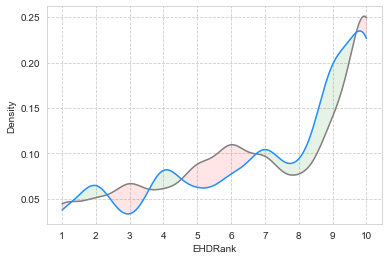

In [228]:


#ax=sns.kdeplot(background.EHDRank, color="grey", bw_adjust=.6,clip=[1,10])
#ax=sns.kdeplot(eval.EHDRank, color="dodgerblue", bw_adjust=.4,clip=[1,10])


#x1 = ax.lines[0].get_xydata()[:,0]
#y1 = ax.lines[0].get_xydata()[:,1]
#x2 = ax.lines[1].get_xydata()[:,0]
#y2 = ax.lines[1].get_xydata()[:,1]

#ax.fill_between(x2,y2,y1, color="green",interpolate=True, alpha=0.1, where=y2>y1)
#ax.fill_between(x2,y2,y1, color="red",interpolate=True, alpha=0.1, where=y1>y2)

#sns.set_style("whitegrid", {'grid.linestyle': '--'})
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1))